In [5]:
import sys
sys.path.append("../../scripts/")
from s3_support import *

import pandas as pd
import numpy as np
%matplotlib inline

# traffic

In [3]:
# new GA data set (update to include bounces, sessions)
q = '''select
            date,
            sum(views) as pageviews,
            sum(bounces) as bounces
        from googleanalytics_traffic_new
        where qgiv_frontend=1
        group by date'''
traffic = redshift_query_read(q, schema="public")
traffic['date'] = pd.to_datetime(traffic['date'])

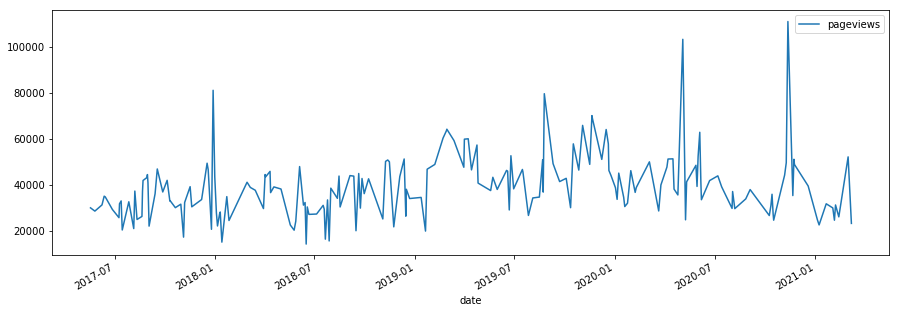

In [16]:
traffic[['date', 'pageviews']].tail(200).plot(x='date', y='pageviews', figsize=(15,5))

In [17]:
# old GA data set (did not include bounces, sessions)
q = '''select
            date,
            sum(views) as pageviews
        from googleanalytics_traffic
        where qgiv_frontend=1
        group by date'''
traffic = redshift_query_read(q, schema="public")
traffic['date'] = pd.to_datetime(traffic['date'])

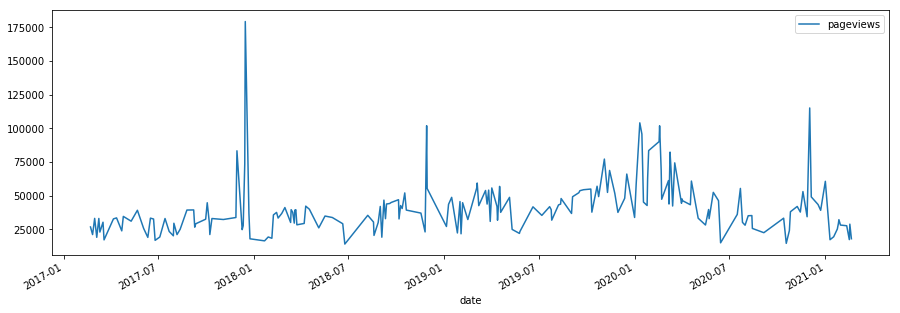

In [18]:
traffic[['date', 'pageviews']].tail(200).plot(x='date', y='pageviews', figsize=(15,5))

# transactions

In [11]:
q = '''select 
            sum(amount) as volume, 
            count(id) as count, 
            date 
        from transactions 
        where 
            status='A' and
            (source='frontend' or source='mobile')
        group by date'''
trans = redshift_query_read(q, schema="public")
trans['date'] = pd.to_datetime(trans['date'])

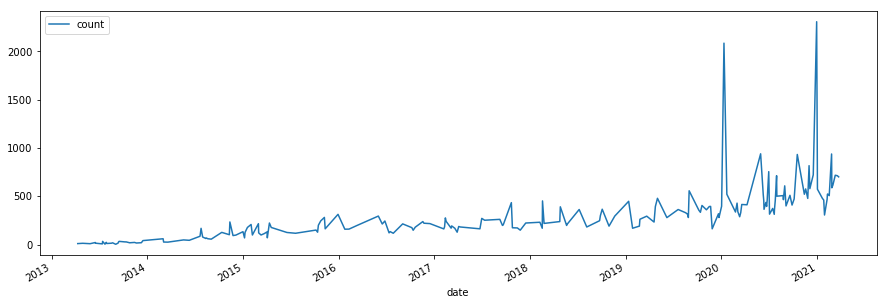

In [15]:
trans[['date', 'count']].tail(200).plot(x='date', figsize=(15,5))

# form checks

- apperance not working confirmed
- recurring CTA? where is the setting? checked form settings & builder

In [2]:
template_upgrades = pd.read_csv("converted_forms_dates.csv")

In [3]:
template_upgrades.head()

,form,created
0,946582,2020-12-09 18:08:29
1,945774,2020-12-09 18:08:04
2,946589,2020-12-09 18:13:16
3,946892,2020-12-11 15:57:53
4,965285,2020-12-10 08:54:36


In [7]:
# ", ".join(["{}".format(f) for f in template_upgrades['form'].tolist()])

# CTA, appearance, conditional fields

In [13]:
q = '''select date, form, appearance, cta_before, cta_after, conditional_fields
        from analyticsqgiv_weekly
        where date_part('year', date) = 2021
        order by date asc;'''
nuform_extra = redshift_query_read(q, schema="public")

In [9]:
print(len(nuform_extra))
nuform_extra.tail(3)

231639


,date,form,appearance,cta_before,cta_after,conditional_fields
231636,2021-01-04,944864,0,0,0,0
231637,2021-01-04,964349,0,0,0,0
231638,2021-01-04,944305,0,0,0,0


In [11]:
nuform_extra[['appearance', 'cta_before', 'cta_after', 'conditional_fields']].describe()

,appearance,cta_before,cta_after,conditional_fields
count,231639.000000,231639.000000,231639.000000,231639.000000
mean,0.480636,0.016793,0.001938,0.003104
std,0.580959,0.128497,0.043984,0.103779
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000
max,2.000000,1.000000,1.000000,13.000000


In [12]:
nuform_extra.groupby('form')[['appearance', 'cta_before', 'cta_after', 'conditional_fields']].mean().describe()

,appearance,cta_before,cta_after,conditional_fields
count,34030.000000,34030.000000,34030.000000,34030.000000
mean,0.491376,0.020136,0.002561,0.003416
std,0.199926,0.073176,0.030934,0.062043
min,0.000000,0.000000,0.000000,0.000000
25%,0.428571,0.000000,0.000000,0.000000
50%,0.428571,0.000000,0.000000,0.000000
75%,0.428571,0.000000,0.000000,0.000000
max,2.000000,1.000000,1.000000,4.000000


# recurring frequencies

1. pull all frontend recurring transactions
2. calculate average time diff between each recurring entry
3. store: originating ID, average frequency

In [14]:
q = '''select 
            form,
            date,
            recurring,
            amount
        from transactions 
        where 
            status='A' and
            (source='frontend' or source='mobile') and
            recurring!=0 and
            date_part('year', date)>=2017'''
rec = redshift_query_read(q, schema="public")
rec['date'] = pd.to_datetime(rec['date'])
rec.sort_values('date', ascending=True, inplace=True)

In [15]:
len(rec), len(rec['recurring'].unique()), len(rec['form'].unique())

(158120, 15755, 1797)

In [41]:
date_diff_data = []
for r in rec['recurring'].unique().tolist():
    _this_rec = rec[rec['recurring']==r]
    date_diff_data.append({
        'recurring': r,
        'form': _this_rec['form'].iloc[0],
        'frequency': _this_rec['date'].diff().mean(),
        'created': _this_rec['date'].min()
    })

In [42]:
date_diff = pd.DataFrame(date_diff_data)

In [43]:
print(len(date_diff), date_diff['frequency'].mean())
date_diff.tail()

15755 25 days 15:30:19.035327175


,recurring,form,frequency,created
15750,1154174,787528,0 days,2021-04-11
15751,1154135,872575,0 days,2021-04-11
15752,1153420,134242,NaT,2021-04-11
15753,1154176,123976,0 days,2021-04-11
15754,1150614,915637,NaT,2021-04-11


In [44]:
#date_diff.to_csv("recurring_frequencies.csv", index=False)